In [1]:
from lib import Estimator, load_dataset
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
X_val, y_val, X_test, y_test = load_dataset("../dataset")

In [3]:
X_val_bgr = [cv2.cvtColor(img, cv2.COLOR_RGB2BGR) for img in X_val]

In [4]:
def show_image(img, to_rgb=True):
    if to_rgb:
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        rgb = img
    plt.imshow(rgb,interpolation='nearest')
    plt.show()

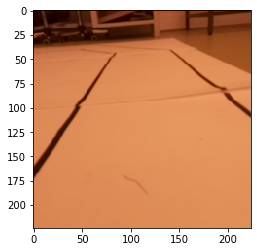

In [5]:
show_image(X_val_bgr[200])

In [6]:
class Config:
    def __init__(self, *args, **kwargs):
        self._d = kwargs
    def __getattr__(self, name):
        return self._d[name]

In [7]:
config = Config(
    gaussian_blur_kernel_size=(3, 3),
    gaussian_blur_sigma_x=1,
    top_offset_pct=0.3,
    canny_threshold1=100,
    canny_threshold2=200,
    houghlines_rho=1,
    houghlines_theta=np.pi/180,
    houghlines_threshold=70,
)

In [8]:
from math import isclose

def get_lines(img, show=False):
    if show:
        show_image(img)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if show:
        show_image(gray)
        
    blur = cv2.GaussianBlur(gray, config.gaussian_blur_kernel_size, config.gaussian_blur_sigma_x)
    if show:
        show_image(blur)

    height, width = blur.shape
#     mask = np.zeros((height, width, 1), np.uint8)
#     mask[int(height * 0.3):height,:] = 1 # (B, G, R)
#     blur_bottom = cv2.bitwise_and(blur, blur, mask=mask)
    offset = int(height * config.top_offset_pct)
    blur_bottom = blur[offset:height,:]
    if show:
        show_image(blur_bottom)
    
    edges = cv2.Canny(blur_bottom, config.canny_threshold1, config.canny_threshold2)
#     edges = cv2.Laplacian(blur_bottom, cv2.CV_8U)
    if show:
        show_image(edges)
    
    lines = cv2.HoughLines(edges, config.houghlines_rho, config.houghlines_theta, config.houghlines_threshold)
    img_lines = img.copy()

    for line in lines:
        for rho, theta in line:
#             if isclose(theta, np.pi/2, rel_tol = 1e-05):
#                 continue
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))

            cv2.line(img_lines, (x1, y1+offset), (x2, y2+offset), (0, 0, 255), 2)
    if show:
        show_image(img_lines)
            
    return lines, img_lines
    

In [9]:
begin = time.time()
get_lines(X_val_bgr[200])
end = time.time()
print(f"get_lines took {end-begin:.3}s")

get_lines took 0.00279s


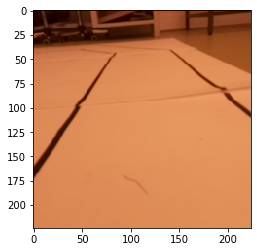

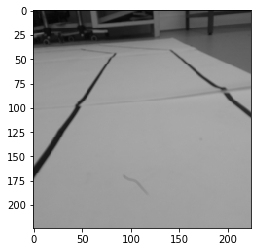

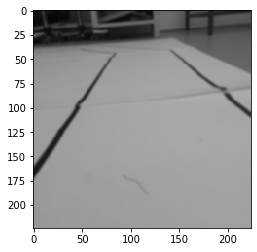

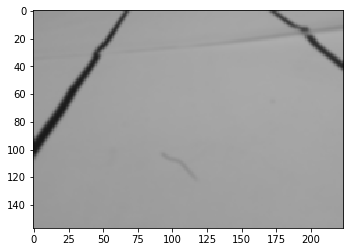

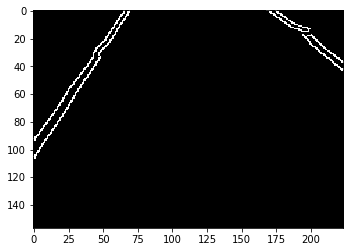

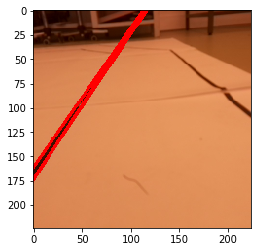

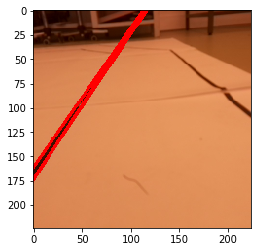

In [10]:
show_image(get_lines(X_val_bgr[200], show=True)[1])

In [11]:
img_set = [X_val_bgr[i] for i in range(0, 3000, 200)]

In [12]:
img_lines_set = [get_lines(img)[1] for img in img_set]

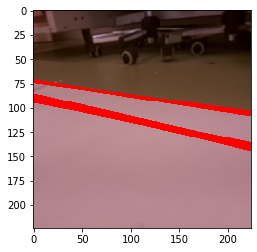

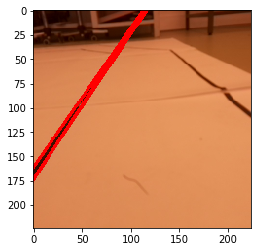

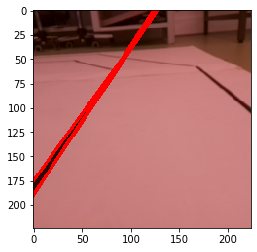

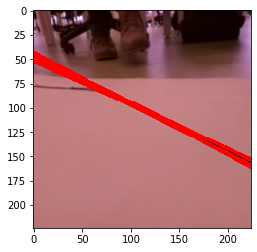

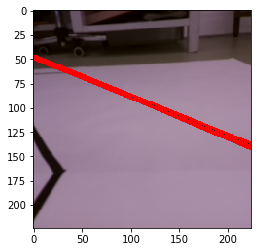

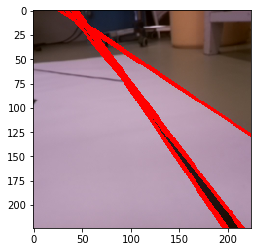

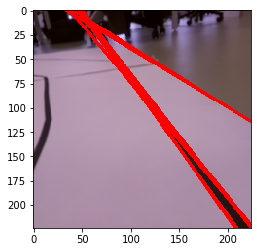

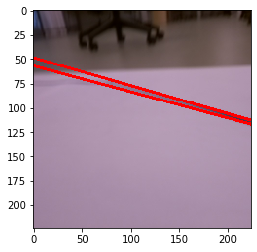

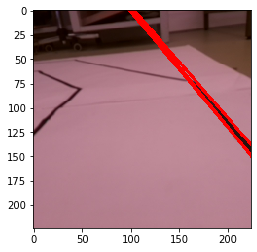

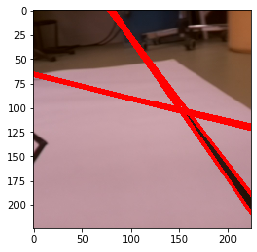

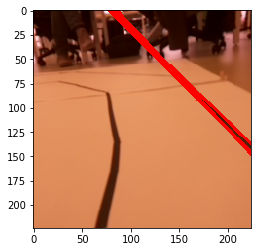

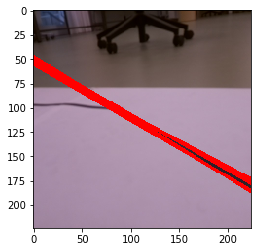

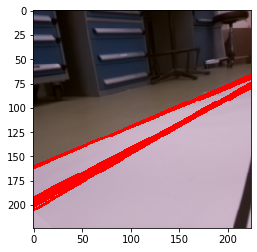

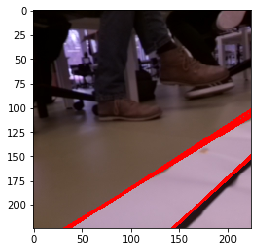

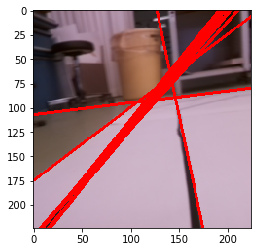

In [13]:
for img_lines in img_lines_set:
    show_image(img_lines)